In [17]:
from tools import *
%matplotlib notebook
from make_synmags import Spec_mags
from astropy.modeling.blackbody import BlackBody1D
from astropy import units as u
from extinction import odonnell94
import sys
sys.path.append('../extinction/')
from extcurve_s16 import extcurve
from copy import deepcopy

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
def line(x, c1, c2): 
    return c1 + c2*x #+ c3*x**2

def func(vals,x,y):
    fit = line(x,vals[0],vals[1])
    return np.nansum(abs(fit-y))

def calculate_R(m_int,m_e):
    gr = m_int['ps1g']-m_int['ps1i']
    ind = (gr < 1) #& (gr > -.2)
    x = deepcopy(gr)
    x = x[ind]
    
    R = {}
    bands = list(m_int.keys())
    for b in bands:
        y = deepcopy((m_e[b]-m_int[b]))/.1
        y = y[ind]
        vals = minimize(func, [0,0], args=(x, y)).x
        fit = line(x, vals[0], vals[1])
        clip = ~sigma_clip(y-fit,3,maxiters=10).mask
        #vals, pcov = curve_fit(line, x[clip], y[clip])
        vals = minimize(func, [0,0,0], args=(x, y)).x
        fit = line(x, vals[0], vals[1])
        clip = ~sigma_clip(y-fit,3,maxiters=10).mask
        std = np.nanstd(y[clip]-fit[clip])
        R[b] = {'coeff':vals,'std':std}
        
        plt.figure()
        plt.plot(x[clip],y[clip],'.')
        plt.plot(x,fit,'.')
        plt.ylabel('$m_{ext}-m_{int}$')
        plt.xlabel('$(g-r)_{int}$')
        plt.tight_layout()
        s = r'$R_{%(band)s}=%(v1)s %(v2)s(g-i)_{int}$' % {'band':b,'v1':str(np.round(vals[0],3))
                                                                              ,'v2':str(np.round(vals[1],3))}
        plt.text(.5,.8,s,transform=plt.gca().transAxes)
        plt.savefig('R_figs/'+b+'.pdf')
    return R
        
        
    

In [4]:
# Generic load in 

path = '../../data/pickle/'
files = glob(path + '*.dat')
files = [x for x in files if (('ukr' not in x) and ('ukw' not in x))]
def Specs(Specs):
    specs = []
    for spec in Specs:
        model_sed = source_synphot.source.pre_process_source(spec,np.nan,'ps1g',0,Renorm=False)
        specs += [model_sed]
    return specs
#pickle = Specs(files)

passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("Kep")]
#pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("TESS/tess.")]

model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
pbnames = pbs.keys()

In [6]:
path = '/Users/rridden/Documents/work/data/current_calspec/'
current = glob(path+'*.dat')
current = np.array(current)
files = np.array(glob(path+'*.fits'))

# select only the stis models, since those are the most well callibrated sources
ind = []
for i in range(len(current)):
    if ('stis' in current[i]) & ('ngc6681' not in current[i]):
        ind += [i]
ind = np.array(ind)
current = current[ind]

cur = Specs(current)
cur_all = deepcopy(cur)
mags = Spec_mags(cur,pbs,0)
gr = mags['ps1g'] - mags['ps1r']

good = (gr > 0.2) & (gr < 0.7)
cur = Specs(current[good])

Warning, 5 of 3667 bins contained negative fluxes; they have been set to zero.
Warning, 40 of 3660 bins contained negative fluxes; they have been set to zero.
Warning, 5 of 6262 bins contained negative fluxes; they have been set to zero.
Warning, 91 of 6558 bins contained negative fluxes; they have been set to zero.
Warning, 28 of 6262 bins contained negative fluxes; they have been set to zero.
Warning, 3 of 4861 bins contained negative fluxes; they have been set to zero.
Warning, 27 of 6262 bins contained negative fluxes; they have been set to zero.
Warning, 64 of 6262 bins contained negative fluxes; they have been set to zero.
Warning, 25 of 248786 bins contained negative fluxes; they have been set to zero.
Warning, 10 of 6254 bins contained negative fluxes; they have been set to zero.
Warning, 5 of 3889 bins contained negative fluxes; they have been set to zero.
Warning, 17 of 6234 bins contained negative fluxes; they have been set to zero.
Warning, 82 of 6560 bins contained negativ

In [8]:
fzero = Spec_mags(cur_all,pbs,ebv=0)
fone = Spec_mags(cur_all,pbs,ebv=.1)

<IPython.core.display.Javascript object>


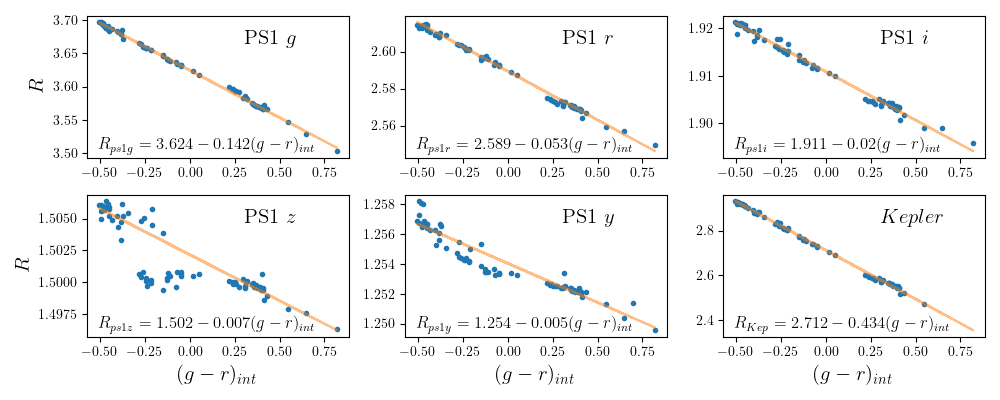

In [20]:
m_int = fzero
m_e = fone
gr = m_int['ps1g']-m_int['ps1r']
ind = (gr < 1) #& (gr > -.2)
x = deepcopy(gr)
x = x[ind]
bb = ['PS1 $g$','PS1 $r$','PS1 $i$','PS1 $z$','PS1 $y$','$Kepler$']
R = {}
bands = list(m_int.keys())
plt.figure(figsize=(10,4))

i = 1
for b in bands:
    y = deepcopy((m_e[b]-m_int[b]))/.1
    y = y[ind]
    vals = minimize(func, [0,0,0], args=(x, y)).x
    fit = line(x, vals[0], vals[1])
    fit = line(x, vals[0], vals[1])
    clip = ~sigma_clip(y-fit,3,maxiters=10).mask
    #vals, pcov = curve_fit(line, x[clip], y[clip])
    vals = minimize(func, [0,0,0], args=(x, y)).x
    fit = line(x, vals[0], vals[1])
    clip = ~sigma_clip(y-fit,3,maxiters=10).mask
    std = np.nanstd(y[clip]-fit[clip])
    R[b] = {'coeff':vals,'std':std}

    plt.subplot(2,3,i)
    plt.plot(x[clip],y[clip],'.')
    plt.plot(x,fit,alpha=.5)
    if i > 3:
        plt.xlabel('$(g-r)_{int}$',fontsize=15)
    if (i == 1) | (i == 4):
        #plt.ylabel('$m_{ext}-m_{int}$',fontsize=15)
        plt.ylabel('$R$',fontsize=15)
    
    s = r'$R_{%(band)s}=%(v2)s %(v1)s(g-r)_{int}$' % {'band':b,'v1':str(np.round(vals[0],3)),'v2':str(np.round(vals[1],3))}
    plt.text(.04,.05,s,transform=plt.gca().transAxes,fontsize=12)
    #plt.title(s,fontsize=12)
    plt.text(.6,.8,bb[i-1],transform=plt.gca().transAxes,fontsize=15)
    i+=1

plt.tight_layout()    
plt.savefig('R_figs/R_all_fits.pdf')

<IPython.core.display.Javascript object>


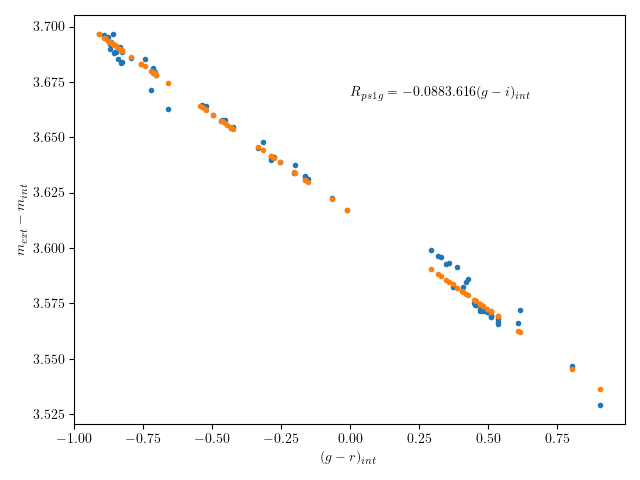

<IPython.core.display.Javascript object>


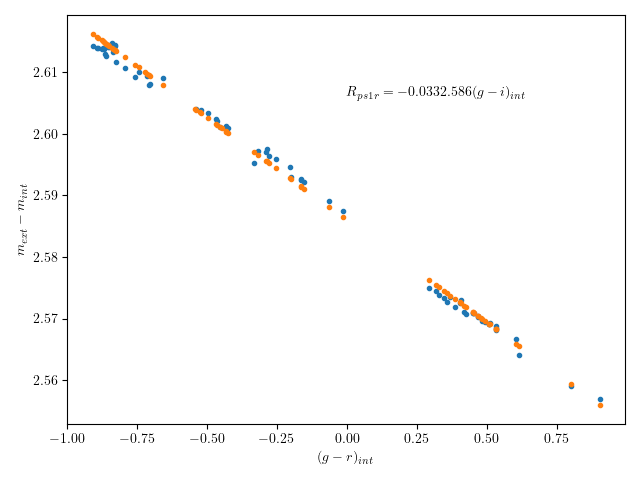

<IPython.core.display.Javascript object>


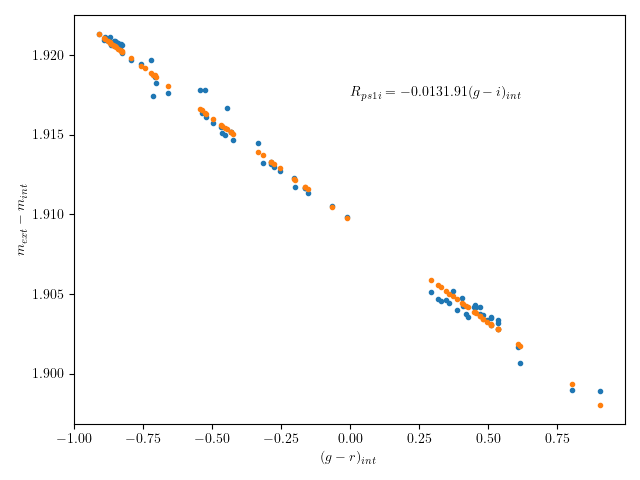

<IPython.core.display.Javascript object>


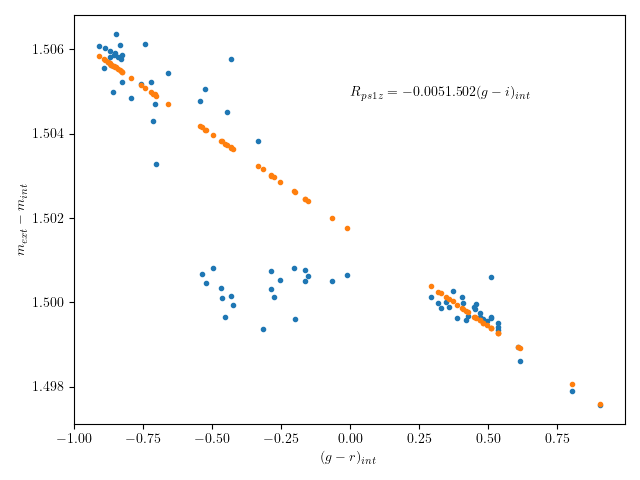

<IPython.core.display.Javascript object>


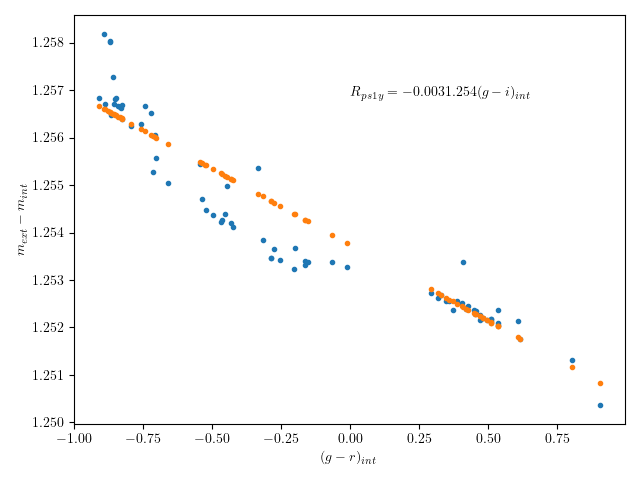

<IPython.core.display.Javascript object>


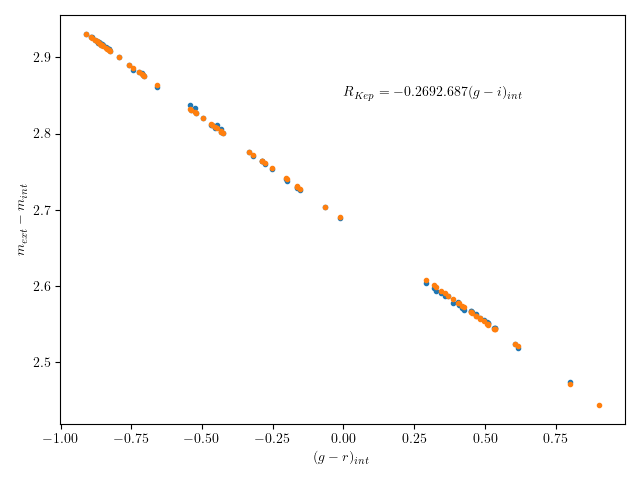

In [21]:
r = calculate_R(fzero,fone)

In [22]:
r

{'ps1g': {'coeff': array([-0.08821786,  3.61625097,  0.        ]),
  'std': 0.003983374957497041},
 'ps1r': {'coeff': array([-0.03324773,  2.58602565,  0.        ]),
  'std': 0.0010612528737322644},
 'ps1i': {'coeff': array([-0.01281381,  1.90961989,  0.        ]),
  'std': 0.00049774242478213},
 'ps1z': {'coeff': array([-0.004548  ,  1.50170317,  0.        ]),
  'std': 0.0014337090650275107},
 'ps1y': {'coeff': array([-0.00321323,  1.25373969,  0.        ]),
  'std': 0.000615615096694815},
 'Kep': {'coeff': array([-0.26852429,  2.68654479,  0.        ]),
  'std': 0.002033498130929614}}